<Axes: >

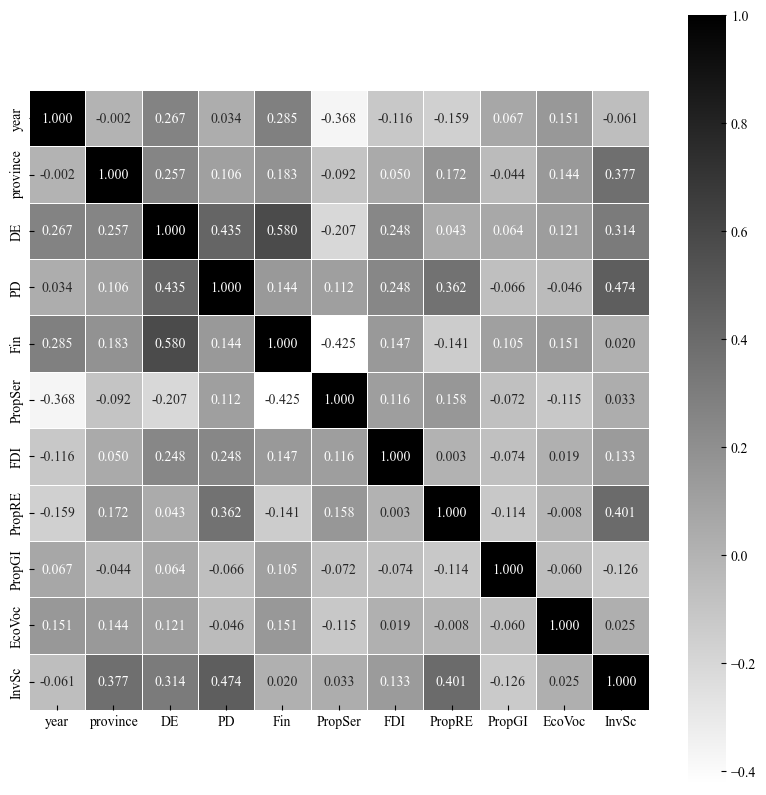

In [13]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pydotplus
import warnings
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay, partial_dependence, permutation_importance
import mpl_toolkits.mplot3d
import matplotlib.ticker as mtick
import shap
from PyALE import ale

# 显示DateFrame所有列
pd.set_option('display.max_columns', None)

plt.rcParams['xtick.direction'] = 'in'  #将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'  #将y轴的刻度方向设置向内

# plt.rcParams['font.sans-serif']= ['Songti SC']  #防止中文乱码
plt.rcParams['font.sans-serif']= ['Times new Roman']

#显示负号
plt.rcParams['axes.unicode_minus'] = True

# 忽略user warning
warnings.filterwarnings("ignore")

# RF随机数
random_seed = 0

# 文件路径
data_path = '/Users/zhuolinli/Documents/小论文数据/数字经济和GTFP数据/Digital Economic Dataset for EL & Panel Regression.xlsx'  # 数据路径
tree_graph_dot_path = '/Users/zhuolinli/Desktop/tree.dot'
tree_graph_png_path = '/Users/zhuolinli/Desktop/tree.jpg'
RF_Feature_Importance_path = '/Users/zhuolinli/Desktop/RF_Feature_Importance.jpg'
RF_PDP_path = '/Users/zhuolinli/Desktop/RF_PDP.jpg'
RF_Both_path = '/Users/zhuolinli/Desktop/RF_Both.jpg'
permutation_importance_path = '/Users/zhuolinli/Desktop/permutation_importance.jpg'
three_pd_path = '/Users/zhuolinli/Desktop/three_pd.jpg'
learning_curve_path = '/Users/zhuolinli/Desktop/learning_curve.tiff'
feature_shap_path = '/Users/zhuolinli/Desktop/feature_shap.tiff'
interaction_dependence_path = '/Users/zhuolinli/Desktop/interaction_dependence.jpg'
ale_path = '/Users/zhuolinli/Desktop/ale.jpg'

# 数据读取与处理
df = pd.DataFrame(pd.read_excel(data_path, header=0))
df['province'] = pd.factorize(df['province'])[0].astype(int)
df['year'] = pd.factorize(df['year'])[0].astype(int)
col_lst = list(df.columns)
for i in ['city', 'year', 'province',
          'Region', 'Rank', 'PolicySup'
         ]:
    col_lst.remove(i)
for col_name in col_lst:
    df[col_name] = winsorize(df[col_name], limits=[0.01, 0.01])  # 上下1%的缩尾

# df = df[df['IsMunicipality']==0]

# 描述性统计结果
des_table = round(df.describe(), 6)
# des_table.to_excel('/Users/zhuolinli/Desktop/data_describe.xlsx')

# 数据选取
data = df.iloc[:, np.r_[1, 2, 6:15
#                         ,18, 24
                       ]]

# 绘制皮尔逊相关系数矩阵热力图
plt.figure(figsize=(10, 10))
corr_df = data.corr()
sns.heatmap(corr_df, cmap="binary", annot=True, vmax=1, square=True, fmt=".3f", linewidth=.5)
# plt.savefig('/Users/zhuolinli/Desktop/heatmap.jpg', dpi=500)
# corr_df.to_excel('/Users/zhuolinli/Desktop/a.xlsx')

In [14]:
data.columns

Index(['year', 'province', 'DE', 'PD', 'Fin', 'PropSer', 'FDI', 'PropRE',
       'PropGI', 'EcoVoc', 'InvSc'],
      dtype='object')

In [15]:
class RF_Regression_Model(object):

    def __init__(self, XTrain, yTrain, XTest, yTest, data):
        self.X_train = XTrain
        self.y_train = yTrain
        self.X_test = XTest
        self.y_test = yTest
        self.data = data
        self.seed = random_seed
        self.NJobs = 6
        self.cv = 3
        self.n_estimators_range = [int(x) for x in np.linspace(400, 1500, 50)]
        self.__max_features_range = ['sqrt', 'log2']
        self.__max_depth_range = [int(x) for x in np.linspace(10, 100, 10)]
        self.__min_samples_split_range = [2, 5, 10]
        self.__min_samples_leaf_range = [1, 2, 4, 8]
        path = DecisionTreeRegressor(random_state=self.seed).cost_complexity_pruning_path(X_train, y_train)
        self.__ccp_alphas = list(path.ccp_alphas)
        self.scoring = {'neg_mse':'neg_mean_squared_error',
                        'neg_mae':'neg_mean_absolute_error',
                        'r2':'r2'}
        self.__criterion = 'squared_error'
        self.best_RF_model = None
        self.y_pred = None

    def __str__(self):
        return self.best_RF_model

    def search_hp_fit(self):
        # 随机搜索选取最优超参数-RandomSearch
        random_forest_hp_range = {'n_estimators': self.n_estimators_range,
                                  'max_features': self.__max_features_range,
                                  'max_depth': self.__max_depth_range,
                                  'min_samples_split': self.__min_samples_split_range,
                                  'min_samples_leaf': self.__min_samples_leaf_range,
                                  'ccp_alpha':self.__ccp_alphas[0:len(self.__ccp_alphas):50]
                                  }

        RF_test_base = RandomForestRegressor(criterion=self.__criterion,
                                             random_state=self.seed)

        RF_test_random = RandomizedSearchCV(estimator=RF_test_base,
                                            param_distributions=random_forest_hp_range,
                                            n_iter=200,
                                            n_jobs=self.NJobs,
                                            cv=KFold(n_splits=self.cv, shuffle=True,
                                                     random_state=self.seed),
                                            random_state=self.seed,
                                            scoring=self.scoring,
                                            refit='neg_mse'
                                            )
        RF_test_random.fit(self.X_train, self.y_train)
        best_hp_Random = RF_test_random.best_params_
        best_hp_dict = best_hp_Random

        # GridSearchCV精准搜索寻找最优超参数：缩小超参数范围，确定最优超参数
        dict_n_estimators = best_hp_dict['n_estimators']
        dict_min_samples_split = best_hp_dict['min_samples_split']
        dict_min_samples_leaf = best_hp_dict['min_samples_leaf']
        dict_max_depth = best_hp_dict['max_depth']
        dict_max_features = best_hp_dict['max_features']
        dict_ccp_alpha = best_hp_dict['ccp_alpha']

        best_hp_dict['n_estimators'] = list(set([
            int(x) for x in range(dict_n_estimators - math.ceil(dict_n_estimators / 10),
                                  dict_n_estimators + math.ceil(dict_n_estimators / 10),
                                  5)
        ]))

        best_hp_dict['min_samples_split'] = list(set([
            int(x) for x in range(
                dict_min_samples_split - math.ceil(dict_min_samples_split / 4),
                dict_min_samples_split + math.ceil(dict_min_samples_split / 4) + 1,
                1)
        ]))

        # min_samples_split 必须大于1
        for k in range(0, len(best_hp_dict.get('min_samples_split'))):
            if best_hp_dict.get('min_samples_split')[k] <= 1:
                best_hp_dict.get('min_samples_split')[k] = 2

        best_hp_dict['min_samples_leaf'] = list(set([
            int(x) for x in range(
                dict_min_samples_leaf - math.ceil(dict_min_samples_leaf / 4),
                dict_min_samples_leaf + math.ceil(dict_min_samples_leaf / 4) + 1,
                1)
        ]))

        # min_samples_leaf 必须大于1
        for k in range(0, len(best_hp_dict.get('min_samples_leaf'))):
            if best_hp_dict.get('min_samples_leaf')[k] <= 1:
                best_hp_dict.get('min_samples_leaf')[k] = 2

        best_hp_dict['max_depth'] = list(set([
            int(x) for x in range(
                dict_max_depth - math.ceil(dict_max_depth / 10),
                dict_max_depth + math.ceil(dict_max_depth / 10) + 1,
                5)
        ]))

        if dict_max_features == 'sqrt':
            best_hp_dict['max_features'] = [math.floor(math.sqrt(self.data.shape[1])),
                                            math.ceil(math.sqrt(self.data.shape[1]))]
        else:
            best_hp_dict['max_features'] = [math.floor(math.log2(self.data.shape[1])),
                                            math.ceil(math.log2(self.data.shape[1]))]

        RF_test_random_Grid = GridSearchCV(estimator=RF_test_base,
                                           param_grid=best_hp_dict,
                                           cv=KFold(n_splits=self.cv, shuffle=True,
                                                    random_state=self.seed),
                                           scoring=self.scoring,
                                           refit='neg_mse',
                                           n_jobs=self.NJobs
                                          )
        
        best_hp_dict['ccp_alpha'] = [dict_ccp_alpha]

        RF_test_random_Grid.fit(self.X_train, self.y_train)
        self.best_RF_model = RF_test_random_Grid.best_estimator_
        self.y_pred = RF_test_random_Grid.predict(self.X_test)

        return self.best_RF_model, self.y_pred

    def Evaluating(self):
        RF_R2 = r2_score(self.y_test, self.y_pred)
        RF_RMSE = mean_squared_error(self.y_test, self.y_pred) ** 0.5
        RF_MAE = mean_absolute_error(self.y_test, self.y_pred)
        print('R_Squared is {:.3f}, RMSE is {:.3f}, MAE is {:.3f}'.format(RF_R2, RF_RMSE, RF_MAE))

    def plot_RF_pred(self):
        plt.scatter(self.y_pred, self.y_test, alpha=0.6)
        w = np.linspace(min(self.y_pred), max(self.y_pred), 100)
        plt.plot(w, w)
        plt.xlabel('y_pred')
        plt.ylabel('y_test')
        plt.title('Random Forest Prediction')
        plt.show()

    def plot_Feature_Importance(self, RF_Feature_Importance_path=None):
        # 绘制变量重要性柱状图
        sorted_index = self.best_RF_model.feature_importances_.argsort()
        a = plt.barh(
            range(self.data.shape[1]),
            np.around(self.best_RF_model.feature_importances_[sorted_index], 3),
            color='darkgray'
        )
        plt.bar_label(a, label_type='edge')
        plt.yticks(np.arange(self.data.shape[1]), self.data.columns[sorted_index])
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        
        if RF_Feature_Importance_path is None:
            plt.show()
        if RF_Feature_Importance_path is not None:
            plt.savefig(RF_Feature_Importance_path)

    def plot_PDP(self, pdp_features, perc=(0.05, 0.95), RF_PDP_path=None):
        # PDP图
        PDP = PartialDependenceDisplay.from_estimator(
            self.best_RF_model,
            self.X_train,
            percentiles=perc,
            features=[pdp_features],
            kind='average',
            line_kw={"color": "darkgray", 'linewidth':3.0},
            n_jobs=self.NJobs
        )
#         plt.title(f'PDP for {self.best_RF_model.__class__.__name__}')
        
        #x、y轴标签字体大小
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        
        #x、y轴标题字体大小
        plt.xlabel("The level of the city's digital economy", fontsize=12)
        plt.ylabel('Partial dependence', fontsize=12)
        
        # 删除图片边框
        ax=plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if RF_PDP_path is None:
            plt.show()
        if RF_PDP_path is not None:
            plt.savefig(RF_PDP_path, dpi=350, bbox_inches='tight')

    def plot_Both(self, both_features, RF_Both_path=None):
        # 绘制PDP & ICE 组合图
        PartialDependenceDisplay.from_estimator(self.best_RF_model,
                                                self.X_train,
                                                features=[both_features],
                                                kind='both',
                                                ice_lines_kw={"color": "darkgray"},
                                                pd_line_kw={"color": "k"},
                                                n_jobs=self.NJobs
                                                )
#         plt.title(f'PDP & ICE for {self.best_RF_model.__class__.__name__}')
        # 删除图片边框
        ax=plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #x、y轴标签字体大小
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        
        #x、y轴标题字体大小
        plt.xlabel("城市数字经济发展水平", fontsize=15)
        plt.ylabel('绿色全要素生产率预测值', fontsize=15)
        
        if RF_Both_path is None:
            plt.show()
        if RF_Both_path is not None:
            plt.savefig(RF_Both_path, dpi=500)
            
    def plot_ale(self, feat, have_CI=False, ale_path=None):
        fig, ax = plt.subplots()
        ale_eff = ale(X=self.data, model=self.best_RF_model,
                      feature=[feat], feature_type="continuous",
                      fig=fig, ax=ax,
                      grid_size=500, include_CI=have_CI)
        
        line = ax.get_lines()
        line[0].set_color('darkgray')
        line[0].set_linewidth(3)
        
        ax.set_title("")
        # 删除图片边框
        ax=plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #x、y轴标签字体大小
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        
        #x、y轴标题字体大小
        plt.xlabel("城市数字经济发展水平", fontsize=15)
        plt.ylabel('ALE值', fontsize=15)
        
        if ale_path is None:
            plt.show()
        if ale_path is not None:
            plt.savefig(ale_path, dpi=1000, bbox_inches='tight')
            
    def plot_3d_pd(self,
                   features1, features2,
                   surface_cmap=plt.get_cmap("Greys"),
                   suptitle=None, sup_fontsize=15,
                   view_elev=45, view_azim=45,
                   colorbar_pad=0.08, colorbar_shrink=0.6, colorbar_aspect=10,
                   three_pd_path=None
                   ):
        fig = plt.figure()
        # 3D偏效应图
        features = [features1, features2]
        pdp = partial_dependence(
            self.best_RF_model,
            self.X_train,
            features=features,
            kind="average",
            grid_resolution=10
        )
        XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
        Z = pdp.average[0].T
        ax = fig.add_subplot(projection="3d")
        fig.add_axes(ax)
        surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=surface_cmap, edgecolor="w")
        
        # x、y、z轴标签字体大小
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        ax.tick_params(axis='z',labelsize=12)
        
        # 标签字体大小
        ax.set_xlabel(features[0], fontsize=12)
        ax.set_ylabel(features[1], fontsize=12)
        ax.zaxis.set_rotate_label(False)  #一定要先关掉默认的旋转设置
        ax.set_zlabel("GMLPI", fontsize=12, rotation = 90)
        
        fig.suptitle(
            suptitle,
            fontsize=sup_fontsize,
        )
        ax.view_init(elev=view_elev, azim=view_azim)  # 3d视角
        clb = plt.colorbar(surf, pad=colorbar_pad,
                           shrink=colorbar_shrink,
                           aspect=colorbar_aspect)
        clb.ax.set_title("Partial\ndependence")
        
        if three_pd_path is None:
            plt.show()
        if three_pd_path is not None:
            plt.savefig(three_pd_path, dpi=600)

    def plot_child_tree(self,
                        child_numb,
                        tree_graph_dot_path=None,
                        tree_graph_png_path=None):

        # 随机森林其中一颗决策树-可视化
        RF_child_tree = self.best_RF_model[child_numb]
        export_graphviz(RF_child_tree, out_file=tree_graph_dot_path,
                        feature_names=self.data.columns, rounded=True, precision=3)

        if tree_graph_dot_path is not None and tree_graph_png_path is not None:
            random_forest_graph = pydotplus.graph_from_dot_file(tree_graph_dot_path)
            random_forest_graph.write_png(tree_graph_png_path)

    def plot_learning_curve(self, data, target,
                            test_line_marker="^", test_line_color="k",
                            scoring="neg_mean_squared_error",
                            score_name="mean_squared_error",
                            train_line_linestyle='dotted', train_line_marker="s",
                            learning_curve_path=None
                            ):
        # 绘制学习曲线图
        _, ax = plt.subplots()
        X = data
        y = target
        common_params = {
            "X": X,
            "y": y,
            "train_sizes": np.linspace(0.1, 1.0, 5),
            "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=self.seed),
            "scoring": scoring,
            "negate_score": True,
            "score_type": "both",
            "n_jobs": self.NJobs,
            "line_kw": {"marker": test_line_marker, "color": test_line_color, 'linewidth':3.0},
            "fill_between_kw": {"color": "lightgray"},
            "std_display_style": "fill_between",
            "score_name": score_name,
        }

        LearningCurveDisplay.from_estimator(estimator=self.best_RF_model, **common_params, ax=ax)
        line1, line2 = ax.get_lines()
        line1.set_linestyle(train_line_linestyle)
        line1.set_marker(train_line_marker)
        handles, label = ax.get_legend_handles_labels()
        ax.legend(handles[:2], ["Training Score", "Test Score"])
#         plt.title(f"Learning Curve for {self.best_RF_model.__class__.__name__}")

        # x、y轴标签字体大小
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        
        # 轴标题字体大小
        plt.xlabel("Training set size", fontsize=10)
        plt.ylabel("Mean square error", fontsize=10)
#         plt.ylabel(f"Score: {score_name}", fontsize=10)

        plt.tight_layout()
        
        # 删除图片边框
        ax=plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if learning_curve_path is None:
            plt.show()
        if learning_curve_path is not None:
            plt.savefig(learning_curve_path, dpi=300)

    def plot_permutation_importance(self, permutation_importance_path=None):
        result = permutation_importance(self.best_RF_model, self.X_train, self.y_train,
                                        n_repeats=10,
                                        random_state=self.seed,
                                        n_jobs=self.NJobs
                                        )
        sorted_idx = result.importances_mean.argsort()
        fig, ax = plt.subplots()
        ax.boxplot(result.importances[sorted_idx].T,
                   vert=False,
                   patch_artist=False,
                   medianprops=dict(color="k"),
                   labels=self.X_train.columns[sorted_idx]
                   )
        ax.set_title("Permutation Importances")
        plt.xlabel("Importances"), plt.ylabel("Variables")
        fig.tight_layout()
        
        if permutation_importance_path is None:
            plt.show()
        if permutation_importance_path is not None:
            plt.savefig(permutation_importance_path, dpi=300)

    def plot_feature_shap(self, feature_shap_path=None):
        
        shap_values = shap.TreeExplainer(self.best_RF_model).shap_values(self.X_train)
        shap_v = pd.DataFrame(shap_values)
        feature_lst = self.X_train.columns
        shap_v.columns = feature_lst
        df_v = self.X_train.copy().reset_index().drop('index', axis=1)

        # 求SHAP值与data的相关系数，判断正负影响
        corr_lst = list()
        for i in feature_lst:
            b = np.corrcoef(shap_v[i], df_v[i])[1][0]
            corr_lst.append(b)
        corr_df = pd.concat([pd.Series(feature_lst), pd.Series(corr_lst)], axis=1).fillna(0)
        corr_df.columns = ['Variable', 'Corr']
        corr_df['Sign'] = np.where(corr_df['Corr'] > 0, '//', '')

        # Plot
        shap_abs = np.abs(shap_v)
        k = pd.DataFrame(shap_abs.mean()).reset_index()
        k.columns = ['Variable', 'SHAP_abs']
        k2_ = k.merge(corr_df, left_on='Variable', right_on='Variable', how='inner')
        k2_ = k2_.sort_values(by='SHAP_abs', ascending=True)
        k2 = np.around(k2_, 4)
        k3 = k2.copy()
        k3.loc[k3['Sign'] == '//', 'SHAP_abs'] = np.nan  # k3仅包含负shap值
        k4 = k2.copy()
        k4.loc[k4['Sign'] == '', 'SHAP_abs'] = np.nan  # k4仅包含正shap值
        k3['SHAP_abs'] = -k3['SHAP_abs']
        hatch_lst = k2['Sign']
        k4.plot.barh(x='Variable', y='SHAP_abs',
                     color='w', edgecolor="k", width=0.75,
                     hatch=hatch_lst, legend=False)
        plt.barh(k3['Variable'], k3['SHAP_abs'], color='w', edgecolor="k", hatch=hatch_lst)
        
#         plt.title("Shapley Additive Explanations")
            
        #x、y轴标签字体大小
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        
        #x、y轴标题字体大小
        plt.xlabel("corr × mean(|Shapley values|)", fontsize=10)
        plt.ylabel('Explanatory variables', fontsize=10)
        
        # 删除图片边框
        ax=plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # x轴保留4位小数
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))
        
        if feature_shap_path is None:
            plt.show()
        if feature_shap_path is not None:
            plt.gcf().subplots_adjust(left=0.2,top=0.91,bottom=0.09)
            plt.savefig(feature_shap_path, dpi=500, bbox_inches='tight')

    def plot_interaction_dependence(self, main_var, other_var, interaction_dependence_path=None):
        cols = [i for i in self.data.columns]
        shap_values = shap.TreeExplainer(self.best_RF_model).shap_values(self.data)
        shap.dependence_plot(main_var,
                             shap_values,
                             self.data[cols],
                             interaction_index=other_var,
                             cmap=plt.get_cmap("tab20c")
                             )
        if interaction_dependence_path is None:
            plt.show()
        if interaction_dependence_path is not None:
            plt.savefig(interaction_dependence_path, dpi=500)


class Bagging_Regression_Model(RF_Regression_Model):

    def __init__(self, XTrain, yTrain, XTest, yTest, data):
        super().__init__(XTrain, yTrain, XTest, yTest, data)  # 继承父类属性
        self.__Bagging_max_samples = list(round(float(x), 2) for x in np.linspace(0.5, 1, 5))
        self.__Bagging_max_features_range = list(range(1, self.data.shape[1] + 1))

    # Baggging 无法计算变量重要性并排序
    plot_Feature_Importance = None
    # Bagging 无法计算SHAP值
    plot_feature_shap = None

    def search_hp_fit(self):
        # 随机搜索选取最优超参数-RandomSearch
        Bagging_hp_range = {'n_estimators': self.n_estimators_range,
                            'max_features': self.__Bagging_max_features_range,
                            'max_samples': self.__Bagging_max_samples
                            }

        # 测试基回归器Bagging
        Bagging_test_base = BaggingRegressor(oob_score=False,
                                             bootstrap=True,
                                             random_state=self.seed,
                                             n_jobs=self.NJobs
                                             )

        Bagging_test_random = RandomizedSearchCV(estimator=Bagging_test_base,
                                                 param_distributions=Bagging_hp_range,
                                                 n_iter=200,
                                                 n_jobs=self.NJobs,
                                                 cv=KFold(n_splits=self.cv, shuffle=True, random_state=self.seed),
                                                 random_state=self.seed,
                                                 scoring=self.scoring,
                                                 refit='neg_mse'
                                                 )

        Bagging_test_random.fit(self.X_train, self.y_train)

        Bagging_best_hp_Random = Bagging_test_random.best_params_
        Bagging_best_hp_dict = Bagging_best_hp_Random

        # GridSearchCV精准搜索寻找最优超参数：缩小超参数范围，确定最优超参数
        Bagging_dict_n_estimators = Bagging_best_hp_dict['n_estimators']
        Bagging_dict_max_samples = Bagging_best_hp_dict['max_samples']

        Bagging_best_hp_dict['n_estimators'] = [
            int(x) for x in range(Bagging_dict_n_estimators - math.ceil(Bagging_dict_n_estimators / 10),
                                  Bagging_dict_n_estimators + math.ceil(Bagging_dict_n_estimators / 10),
                                  10)
        ]

        Bagging_best_hp_dict['max_features'] = [math.floor(math.sqrt(self.data.shape[1])),
                                                math.ceil(math.sqrt(self.data.shape[1]))]

        Bagging_best_hp_dict['max_samples'] = [round(float(x), 3) for x in np.linspace(Bagging_dict_max_samples + 0.1,
                                                                                       Bagging_dict_max_samples - 0.1,
                                                                                       5)
                                               ]
        # max_samples 小于等于1
        for k in range(0, len(Bagging_best_hp_dict.get('max_samples'))):
            if Bagging_best_hp_dict.get('max_samples')[k] > 1:
                Bagging_best_hp_dict.get('max_samples')[k] = 1

        Bagging_test_random_Grid = GridSearchCV(estimator=Bagging_test_base,
                                                param_grid=Bagging_best_hp_dict,
                                                cv=KFold(n_splits=self.cv, shuffle=True, random_state=self.seed),
                                                scoring=self.scoring,
                                                n_jobs=self.NJobs,
                                                refit='neg_mse'
                                                )

        Bagging_test_random_Grid.fit(self.X_train, self.y_train)
        self.best_RF_model = Bagging_test_random_Grid.best_estimator_
        self.y_pred = Bagging_test_random_Grid.predict(self.X_test)

        return self.best_RF_model, self.y_pred


class GBDT_Regression_Model(RF_Regression_Model):

    def __init__(self, XTrain, yTrain, XTest, yTest, data):
        super().__init__(XTrain, yTrain, XTest, yTest, data)  # 继承父类属性
        self.__Boosting_max_depth_range = [int(x) for x in np.linspace(0, 20, num=10)]
        self.__Boosting_min_samples_split_range = [1, 2, 5, 10]
        self.__Boosting_min_samples_leaf_range = [1, 2, 4, 8]
        self.__sub_sample = [round(float(x), 3) for x in np.linspace(0.5, 1, 5)]
        self.__learning_rate = [round(float(x), 3) for x in np.linspace(0.01, 0.2, 5)]
        self.__alpha = [round(float(x), 3) for x in np.linspace(0.8, 0.99, 5)]
        self.__loss_fuc = 'huber'

    plot_child_tree = None

    def search_hp_fit(self):
        Boosting_hp_range = {'n_estimators': self.n_estimators_range,
                             'max_depth': self.__Boosting_max_depth_range,
                             'min_samples_split': self.__Boosting_min_samples_split_range,
                             'min_samples_leaf': self.__Boosting_min_samples_leaf_range,
                             'subsample': self.__sub_sample,
                             'learning_rate': self.__learning_rate,
                             'alpha': self.__alpha
                             }

        GBDT_test_base = GradientBoostingRegressor(loss=self.__loss_fuc,
                                                   # 提前停止防止过拟合
                                                   # validation_fraction=0.1,
                                                   # n_iter_no_change=5, tol=0.01,
                                                   random_state=self.seed)

        GBDT_test_random = RandomizedSearchCV(estimator=GBDT_test_base,
                                              param_distributions=Boosting_hp_range,
                                              n_iter=200,
                                              n_jobs=self.NJobs,
                                              cv=KFold(n_splits=self.cv, shuffle=True, random_state=self.seed),
                                              random_state=self.seed,
                                              refit='neg_mse',
                                              scoring=self.scoring
                                              )

        GBDT_test_random.fit(self.X_train, self.y_train)
        GBDT_best_hp_Random = GBDT_test_random.best_params_
        GBDT_best_hp_dict = GBDT_best_hp_Random

        # GridSearchCV精准搜索寻找最优超参数：缩小超参数范围，确定最优超参数
        GBDT_dict_n_estimators = GBDT_best_hp_dict['n_estimators']
        GBDT_min_samples_split = GBDT_best_hp_dict['min_samples_split']
        GBDT_dict_min_samples_leaf = GBDT_best_hp_dict['min_samples_leaf']
        GBDT_dict_max_depth = GBDT_best_hp_dict['max_depth']
        GBDT_dict_subsample = GBDT_best_hp_dict['subsample']
        GBDT_dict_learning_rate = GBDT_best_hp_dict['learning_rate']
        GBDT_dict_alpha = GBDT_best_hp_dict['alpha']

        GBDT_best_hp_dict['n_estimators'] = [GBDT_dict_n_estimators]
        GBDT_best_hp_dict['min_samples_split'] = [GBDT_min_samples_split]
        GBDT_best_hp_dict['min_samples_leaf'] = [GBDT_dict_min_samples_leaf]
        GBDT_best_hp_dict['max_depth'] = [GBDT_dict_max_depth]

        GBDT_best_hp_dict['subsample'] = [
            round(float(x), 3) for x in np.linspace(GBDT_dict_subsample - 0.1, GBDT_dict_subsample + 0.1, 5)
        ]

        # subsample 必须在区间（0,1）内
        for i in range(0, len(GBDT_best_hp_dict.get('subsample'))):
            if GBDT_best_hp_dict.get('subsample')[i] <= 0:
                GBDT_best_hp_dict.get('subsample')[i] = 0.5

            if GBDT_best_hp_dict.get('subsample')[i] >= 1:
                GBDT_best_hp_dict.get('subsample')[i] = 1

        GBDT_best_hp_dict['learning_rate'] = [
            round(float(x), 3) for x in np.linspace(
                GBDT_dict_learning_rate - 0.1, GBDT_dict_learning_rate + 0.1, 5
            )
        ]

        # learning_rate 必须在区间（0,1）内
        for i in range(0, len(GBDT_best_hp_dict.get('learning_rate'))):
            if GBDT_best_hp_dict.get('learning_rate')[i] <= 0:
                GBDT_best_hp_dict.get('learning_rate')[i] = 0.01

            if GBDT_best_hp_dict.get('learning_rate')[i] >= 1:
                GBDT_best_hp_dict.get('learning_rate')[i] = 0.2

        GBDT_best_hp_dict['alpha'] = [
            round(float(x), 3) for x in np.linspace(
                GBDT_dict_alpha - 0.1, GBDT_dict_alpha + 0.1, 5
            )
        ]

        # alpha 必须在区间（0,1）内
        for i in range(0, len(GBDT_best_hp_dict.get('alpha'))):
            if GBDT_best_hp_dict.get('alpha')[i] <= 0:
                GBDT_best_hp_dict.get('alpha')[i] = 0.8

            if GBDT_best_hp_dict.get('alpha')[i] >= 1:
                GBDT_best_hp_dict.get('alpha')[i] = 0.99

        GBDT_test_random_Grid = GridSearchCV(estimator=GBDT_test_base,
                                             param_grid=GBDT_best_hp_dict,
                                             cv=KFold(n_splits=self.cv, shuffle=True, random_state=self.seed),
                                             scoring=self.scoring,
                                             n_jobs=self.NJobs,
                                             refit='neg_mse'
                                             )

        GBDT_test_random_Grid.fit(self.X_train, self.y_train)

        # 使用最优超参数拟合模型
        self.best_RF_model = GBDT_test_random_Grid.best_estimator_
        self.y_pred = GBDT_test_random_Grid.predict(self.X_test)

        return self.best_RF_model, self.y_pred
    

In [16]:
# 指定target
target = df['TFPCH']

# 设定训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.2,
                                                    random_state=random_seed)

In [16]:
# 机制检验
df_mec = df.copy()
df_mec = df.dropna(axis=0, how='any', subset='ASY')

# 指定target
mech_target = df_mec['ASY']
mech_data = df_mec.iloc[:, np.r_[1, 2, 6:15]]

# 设定训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(mech_data, mech_target,
                                                    test_size=0.2,
                                                    random_state=random_seed)

In [4]:
# 机制检验 第二步
df_mec = df.copy()
df_mec = df.dropna(axis=0, how='any', subset='KMI')

# 指定target
target = df_mec['KMI']
data = df_mec.iloc[:, np.r_[1, 2, 6:15, 24]]
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.2,
                                                    random_state=random_seed)

In [17]:
model = RandomForestRegressor(ccp_alpha=3.394772771714645e-09, max_depth=9,
                       max_features=4, min_samples_leaf=3, min_samples_split=7,
                       n_estimators=676, random_state=0)

model.fit(X_train, y_train)

clf = RF_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.best_RF_model = model
clf.y_pred = model.predict(X_test)

In [18]:
clf.Evaluating()

R_Squared is 0.195, RMSE is 0.063, MAE is 0.040


In [ ]:
clf.plot_feature_shap(feature_shap_path)

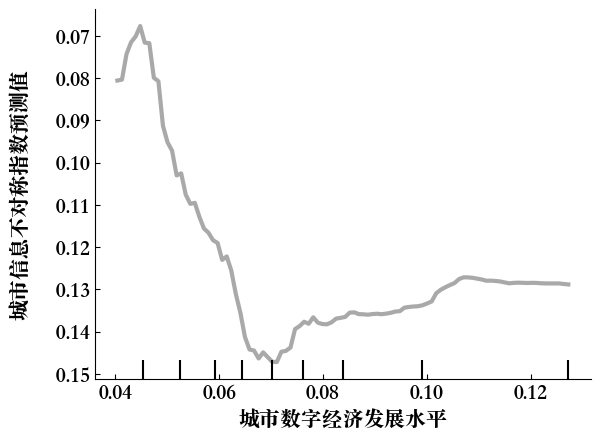

In [146]:
clf.plot_PDP("DE",perc=(0.05, 0.95), RF_PDP_path=RF_PDP_path)

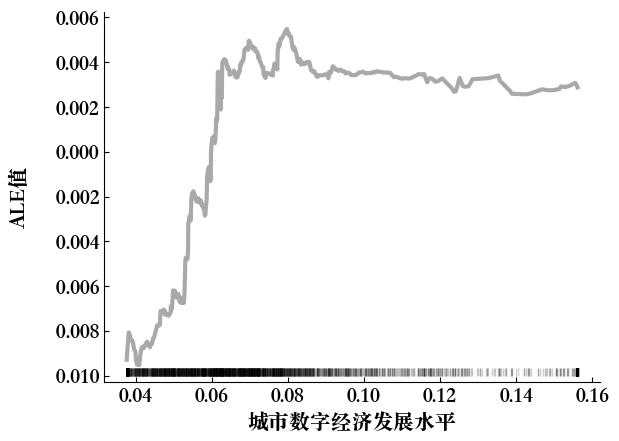

In [76]:
clf.plot_ale("DE", ale_path=ale_path)

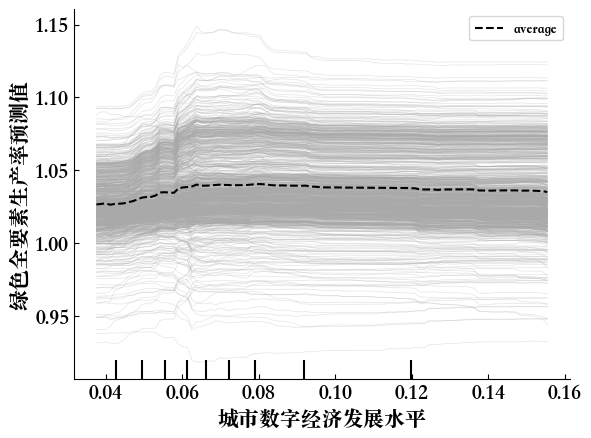

In [60]:
clf.plot_Both("DE", RF_Both_path=RF_Both_path)

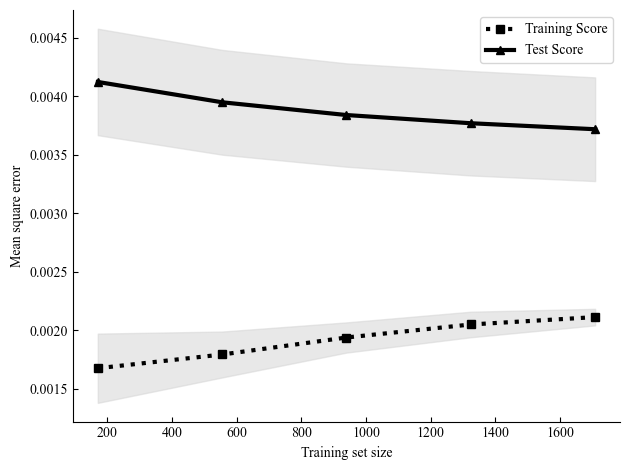

In [10]:
clf.plot_learning_curve(data, target, learning_curve_path=learning_curve_path)

In [15]:
model = BaggingRegressor(max_features=4, max_samples=0.9, n_estimators=943, n_jobs=6,
                  random_state=0)

model.fit(X_train, y_train)

clf = Bagging_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.best_RF_model = model
clf.y_pred = model.predict(X_test)

In [16]:
clf.Evaluating()

R_Squared is 0.161, RMSE is 0.064, MAE is 0.041


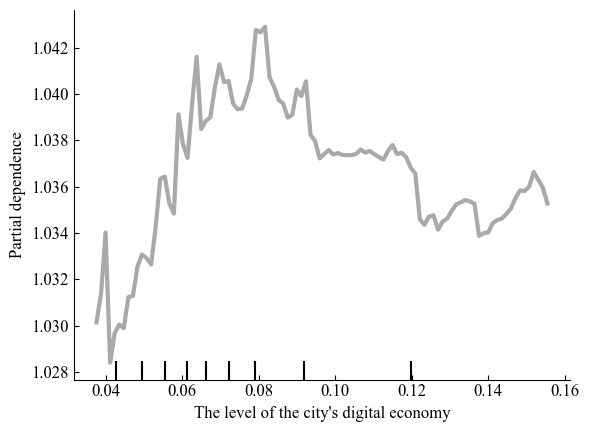

In [17]:
clf.plot_PDP("DE", RF_PDP_path='/Users/zhuolinli/Desktop/Bagging_PDP.tiff')

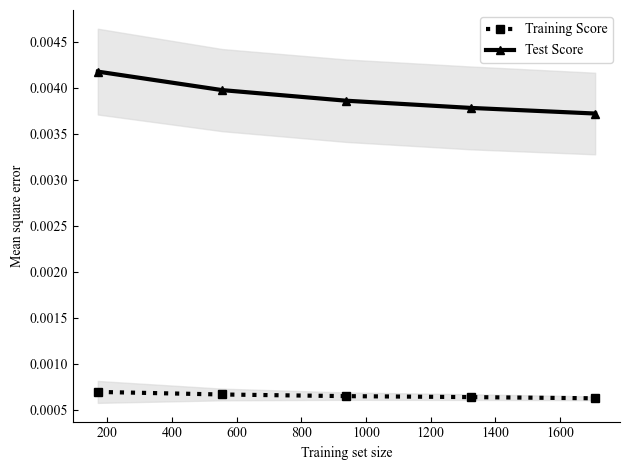

In [18]:
clf.plot_learning_curve(data, target, learning_curve_path='/Users/zhuolinli/Desktop/Bagging_learning_curve.tiff')

In [19]:
model = GradientBoostingRegressor(alpha=0.795, learning_rate=0.01, loss='huber',
                           max_depth=4, min_samples_leaf=4, min_samples_split=10,
                           n_estimators=646, random_state=0, subsample=0.8)

model.fit(X_train, y_train)

clf = GBDT_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.best_RF_model = model
clf.y_pred = model.predict(X_test)

In [20]:
clf.Evaluating()

R_Squared is 0.207, RMSE is 0.062, MAE is 0.040


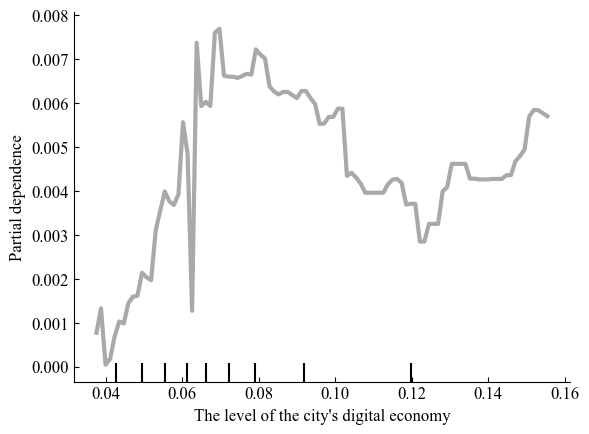

In [21]:
clf.plot_PDP("DE", RF_PDP_path='/Users/zhuolinli/Desktop/GBDT_PDP.tiff')

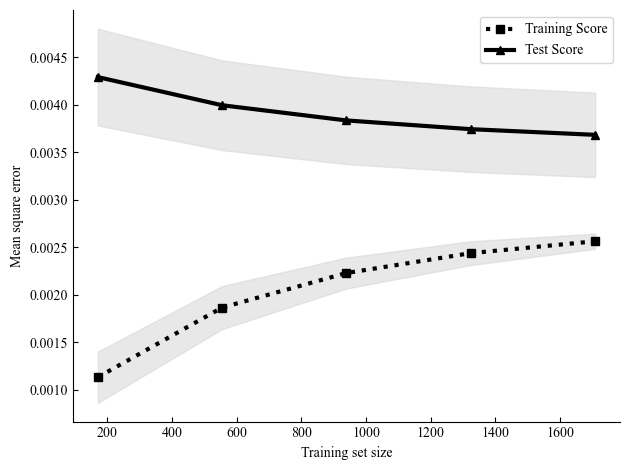

In [22]:
clf.plot_learning_curve(data, target, learning_curve_path='/Users/zhuolinli/Desktop/GBDT_learning_curve.tiff')

In [108]:
model = RandomForestRegressor(ccp_alpha=4.68175833821016e-07, max_depth=96,
                       max_features=3, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=676, random_state=0)

model.fit(X_train, y_train)

clf = RF_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.best_RF_model = model
clf.y_pred = model.predict(X_test)

In [109]:
clf.Evaluating()

R_Squared is 0.180, RMSE is 0.063, MAE is 0.041


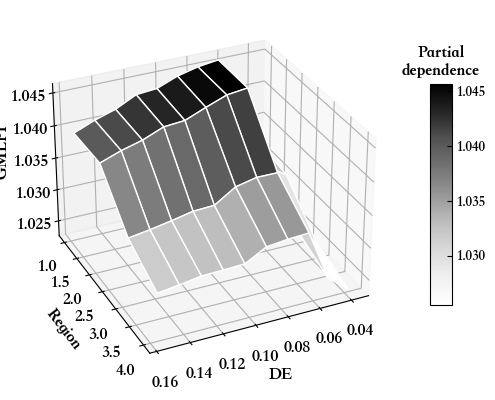

In [107]:
clf.plot_3d_pd("DE", "Region", view_elev=30, view_azim=65,
               three_pd_path='/Users/zhuolinli/Desktop/three_pd_region.jpg')

In [114]:
model = RandomForestRegressor(ccp_alpha=1.216098728588242e-07, max_depth=9,
                       max_features=3, min_samples_leaf=4, min_samples_split=11,
                       n_estimators=869, random_state=0)

model.fit(X_train, y_train)

clf = RF_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.best_RF_model = model
clf.y_pred = model.predict(X_test)

In [115]:
clf.Evaluating()

R_Squared is 0.175, RMSE is 0.064, MAE is 0.041


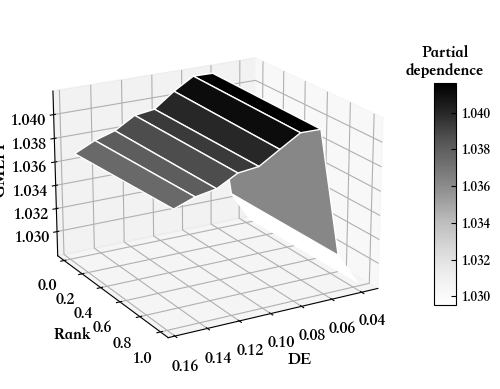

In [116]:
clf.plot_3d_pd("DE", "Rank", view_elev=20, view_azim=60,
               three_pd_path='/Users/zhuolinli/Desktop/three_pd_rank.jpg')

In [121]:
model = RandomForestRegressor(ccp_alpha=3.394772771389828e-09, max_depth=96,
                       max_features=3, min_samples_leaf=2, n_estimators=546,
                       random_state=0)

model.fit(X_train, y_train)

clf = RF_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.best_RF_model = model
clf.y_pred = model.predict(X_test)

In [122]:
clf.Evaluating()

R_Squared is 0.200, RMSE is 0.063, MAE is 0.040


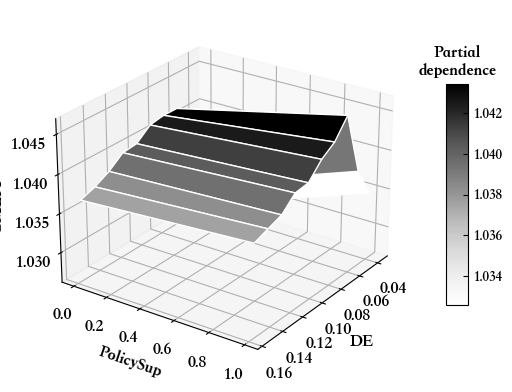

In [123]:
clf.plot_3d_pd("DE", "PolicySup", view_elev=25, view_azim=35,
               three_pd_path='/Users/zhuolinli/Desktop/three_pd_PolicySup.tiff')

In [17]:
model = RandomForestRegressor(ccp_alpha=4.800319387728243e-06, max_depth=72,
                       max_features=4, min_samples_leaf=2, n_estimators=934,
                       random_state=0)

model.fit(X_train, y_train)

clf = RF_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.best_RF_model = model
clf.y_pred = model.predict(X_test)

In [18]:
clf.Evaluating()

R_Squared is 0.420, RMSE is 0.261, MAE is 0.189


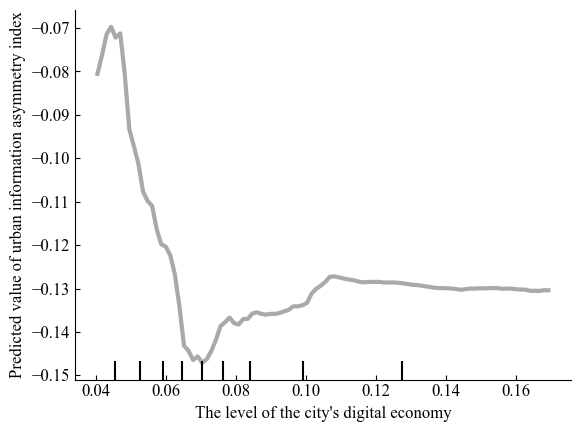

In [19]:
clf.plot_PDP("DE",perc=(0.05,0.95), RF_PDP_path='/Users/zhuolinli/Desktop/aaa_PDP.tiff')

In [126]:
clf = RF_Regression_Model(X_train, y_train, X_test, y_test, data)
clf.search_hp_fit()

(RandomForestRegressor(ccp_alpha=5.833333332245465e-10, max_depth=9,
                       max_features=3, min_samples_leaf=10, n_estimators=824,
                       random_state=0),
 array([1.03006546, 1.07139064, 1.03332863, 1.03207203, 1.0772728 ,
        1.02452674, 1.10230671, 1.02335717, 1.03079306, 1.08996948,
        1.01907736, 1.02984736, 1.03443919, 1.01939216, 1.03339501,
        1.01806847, 1.05865143, 1.02351193, 1.01455403, 1.08000875,
        1.01438459, 1.02920909, 1.08790388, 1.0366045 , 1.07261252,
        1.03413579, 1.06946995, 1.07609048, 1.05793703, 1.06731243,
        1.02463349, 1.03185643, 1.07118592, 1.07383446, 1.05369221,
        1.0376156 , 1.00257928, 1.03420064, 1.01122714, 1.02217385,
        1.01538241, 1.07063047, 1.00142134, 1.02143836, 1.03378309,
        1.07640355, 1.02915947, 1.03517755, 1.0119664 , 1.06733325,
        1.02029036, 1.02426261, 1.02592385, 0.99745834, 1.08484232,
        1.02564868, 1.06725384, 1.06012071, 1.06982416, 1.0115714

In [127]:
clf.Evaluating()

R_Squared is 0.136, RMSE is 0.068, MAE is 0.042
